# Logit Lens Analysis

In [1]:
import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math

sys.path.append("../../model")
from model_params import *

sys.path.append("../../data")
from dataset_params import *
from prompt_params import *
from demo_params import *

## 1) Setup

Select the parameters that you used in your script.

In [2]:
models = [
    "gpt2_xl",
    "gpt_j",
    "gpt_neox_20B",
    "pythia_410M",
    "pythia_2p8B",
    "pythia_6p9B",
    "pythia_12B",
    "gpt2_instruct",
    "gpt_j_instruct",
    "gpt_neox_20B_instruct",
    "llama2_7b",
]
datasets = [
    "sst2",
    "agnews",
    "trec",
    "dbpedia",
    "rte",
    "mrpc",
    "tweet_eval_hate",
    "sick",
    "poem_sentiment",
    "ethos",
    "financial_phrasebank",
    "medical_questions_pairs",
    "tweet_eval_stance_feminist",
    "tweet_eval_stance_atheism",
#     "unnatural",
#     "sst2_ab",
]
settings = [
    "permuted_incorrect_labels",
    # "half_permuted_incorrect_labels",
    # "random_labels",
]

Select the metrics that you're interested in.

In [3]:
metrics = [
#     "label_space_probs",
#     "top_num_labels_match",
#     "top_1_acc",
#     "correct_over_incorrect",
    "cal_correct_over_incorrect",
#     "cal_permute",
]

## 2) Load Results

In [4]:
results = {}
for model in models:
    results[model] = {}
    for setting in settings:
        results[model][setting] = {}
        for dataset in datasets:
            results[model][setting][dataset] = np.load(
                f"../../results/logit_lens/{model}/{setting}/{dataset}.npy",
                allow_pickle=True,
            ).item()

## 3) Layerwise Plots

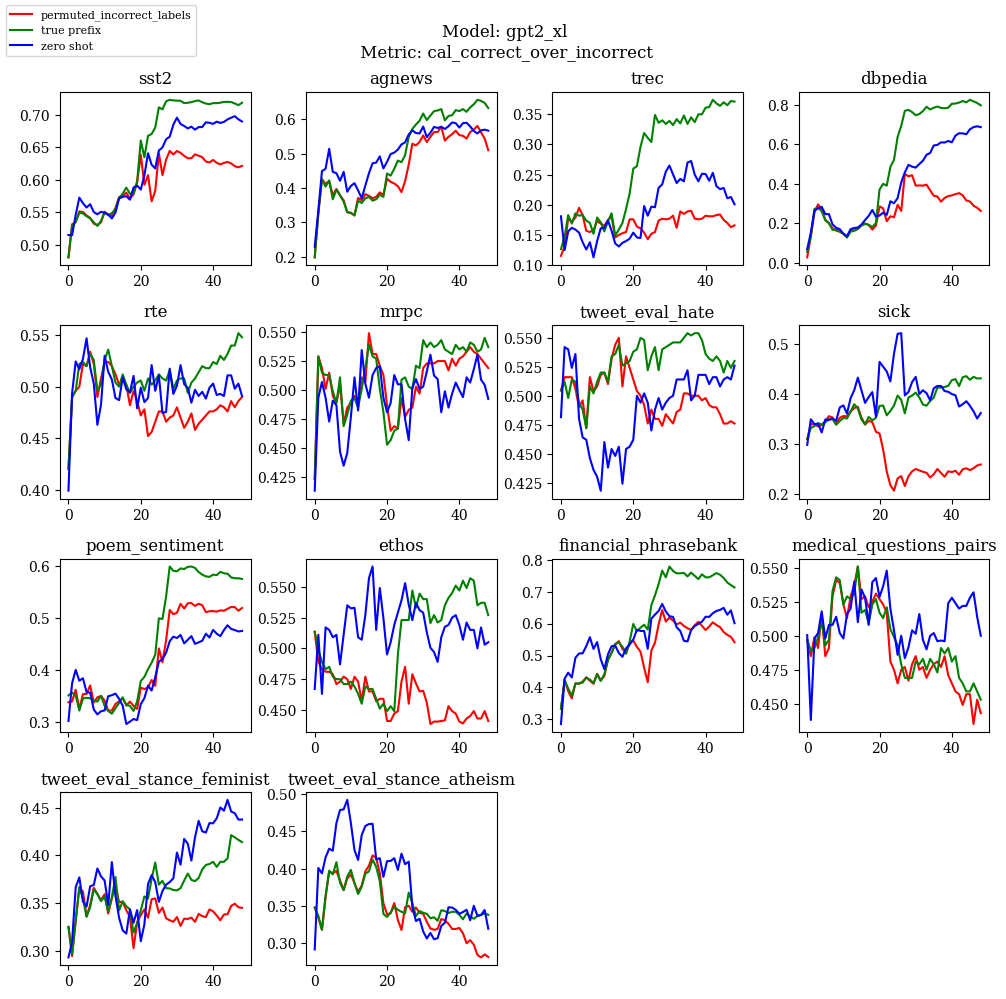

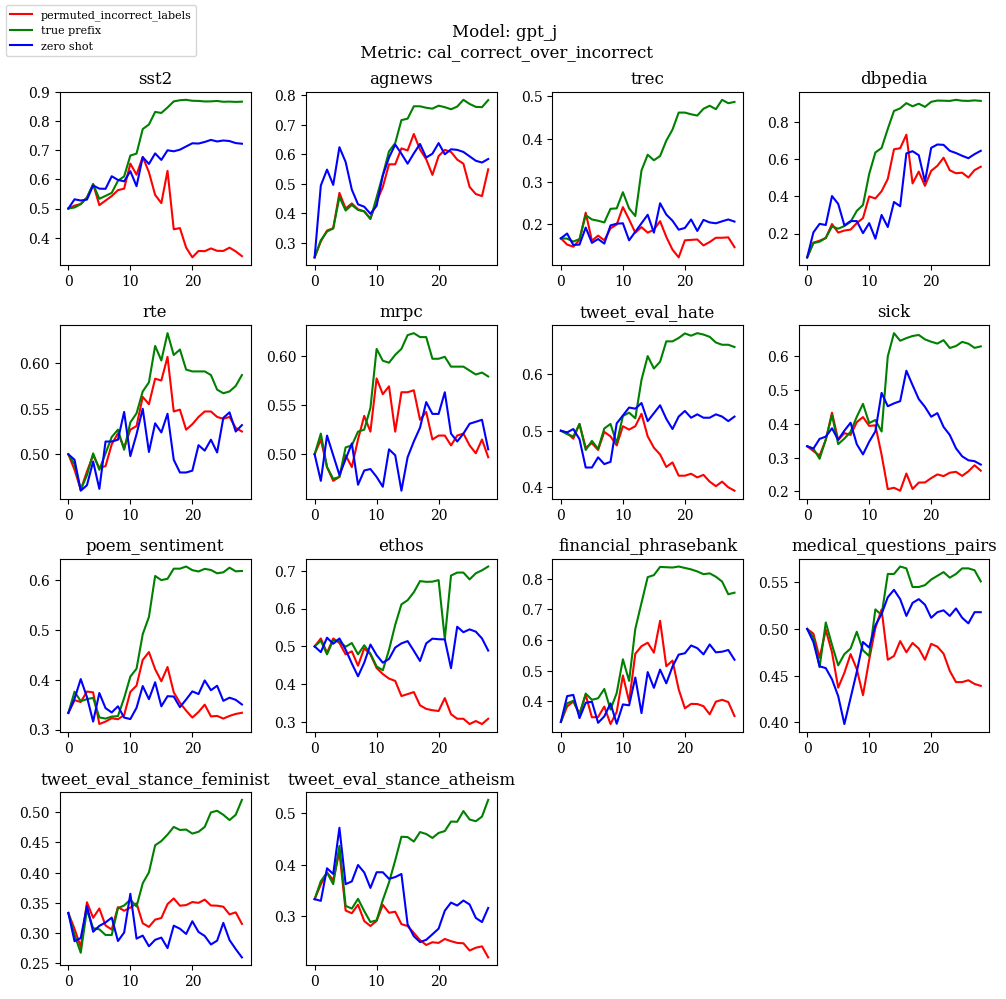

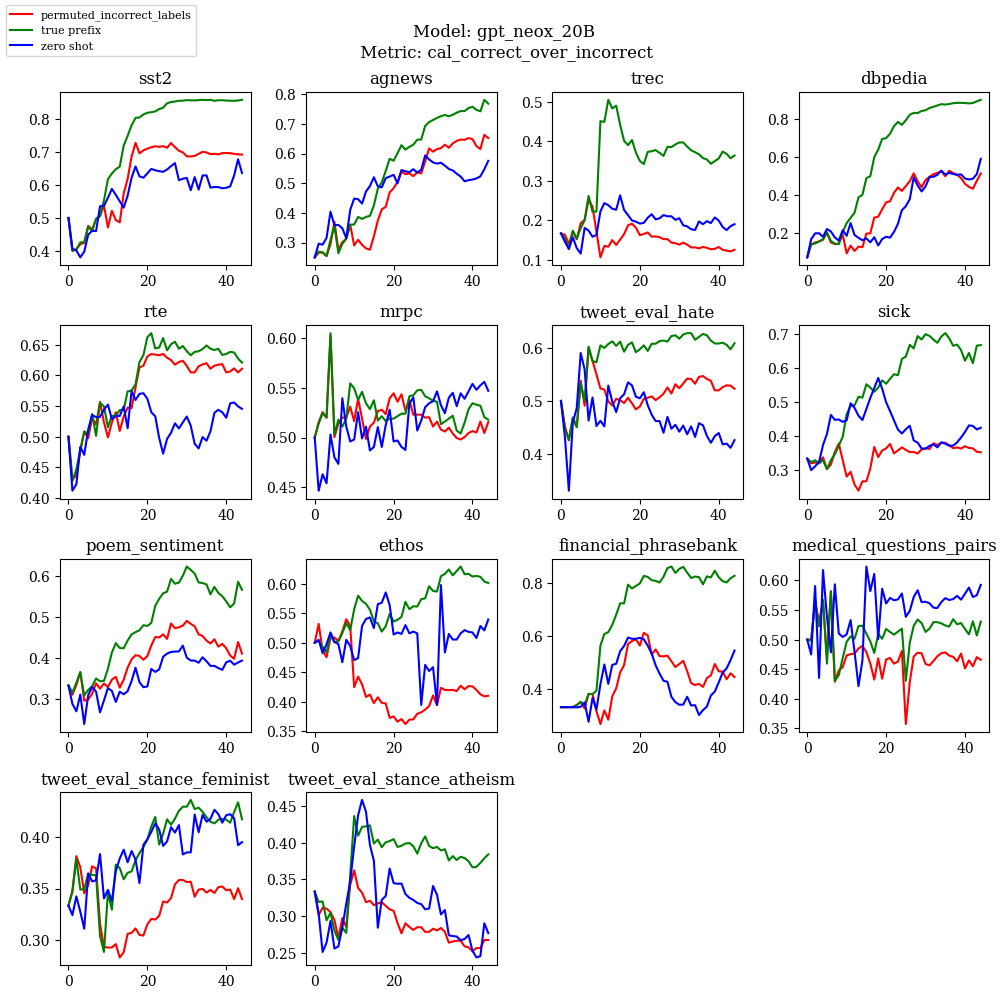

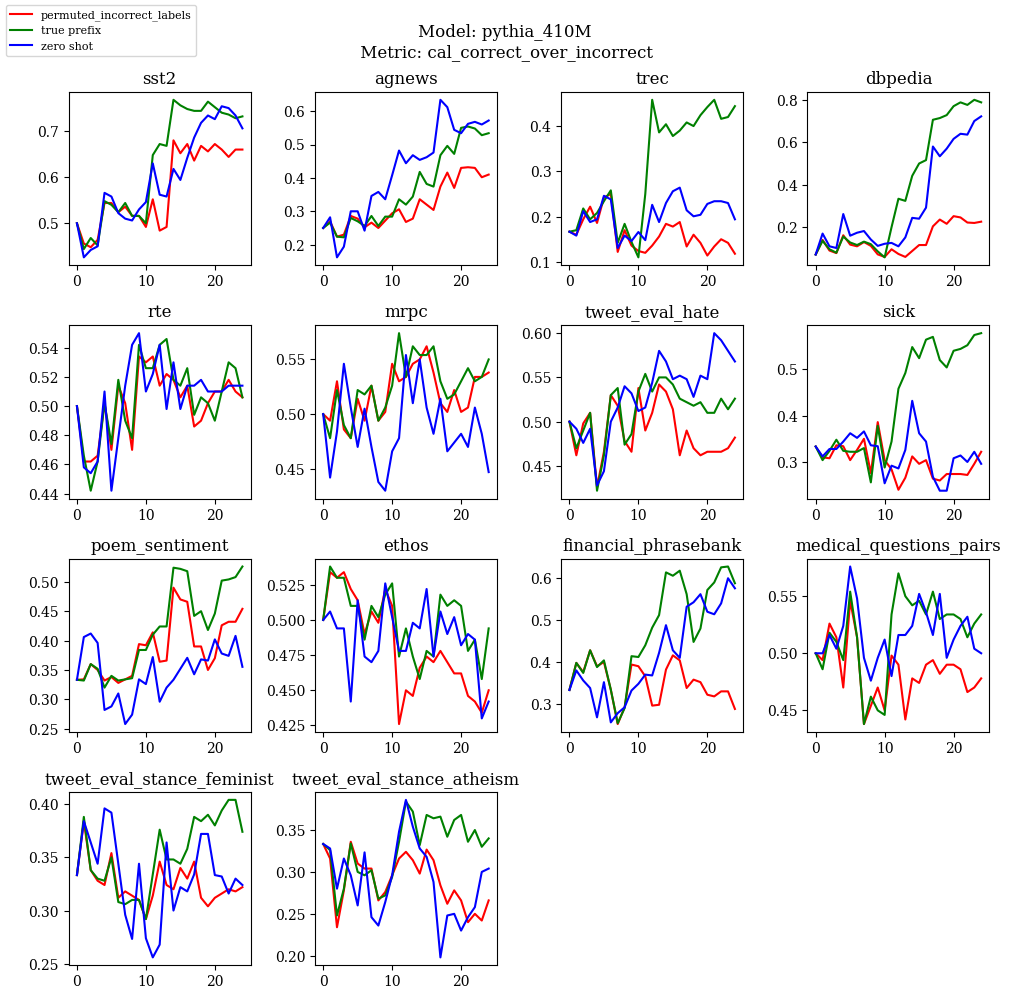

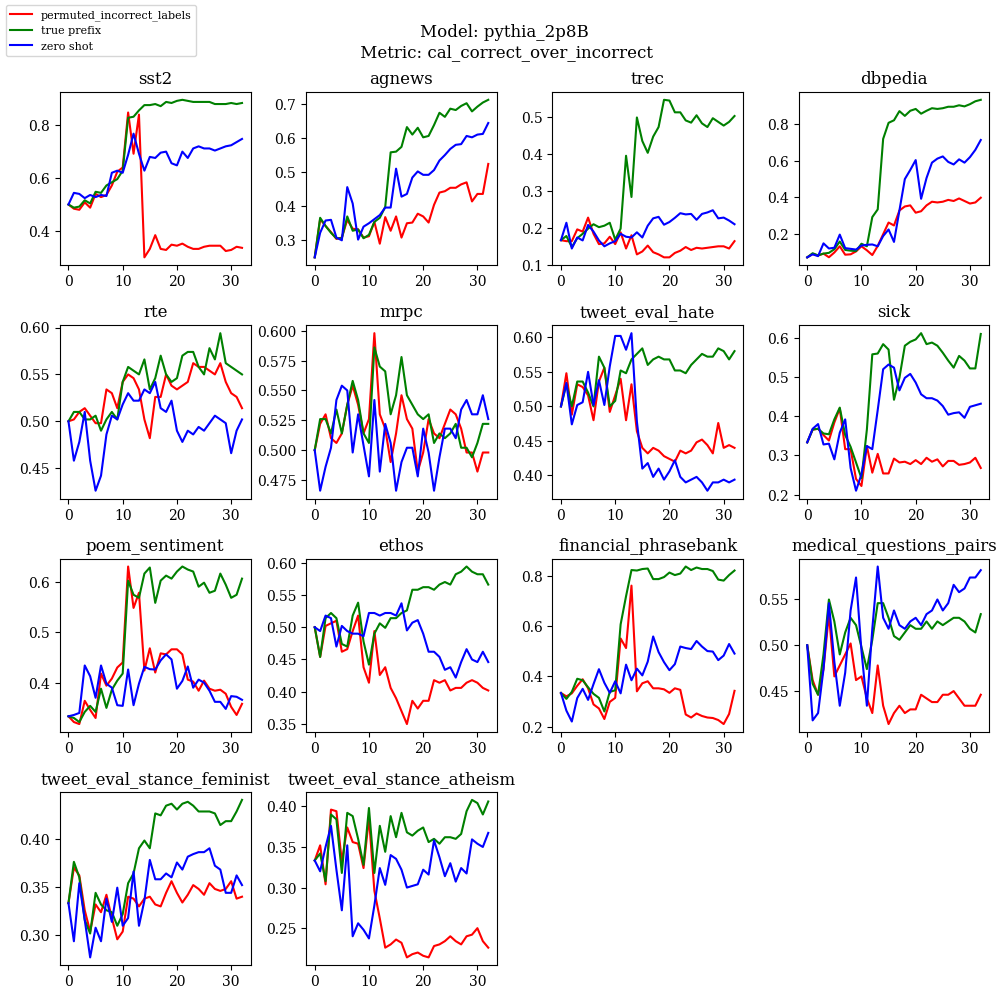

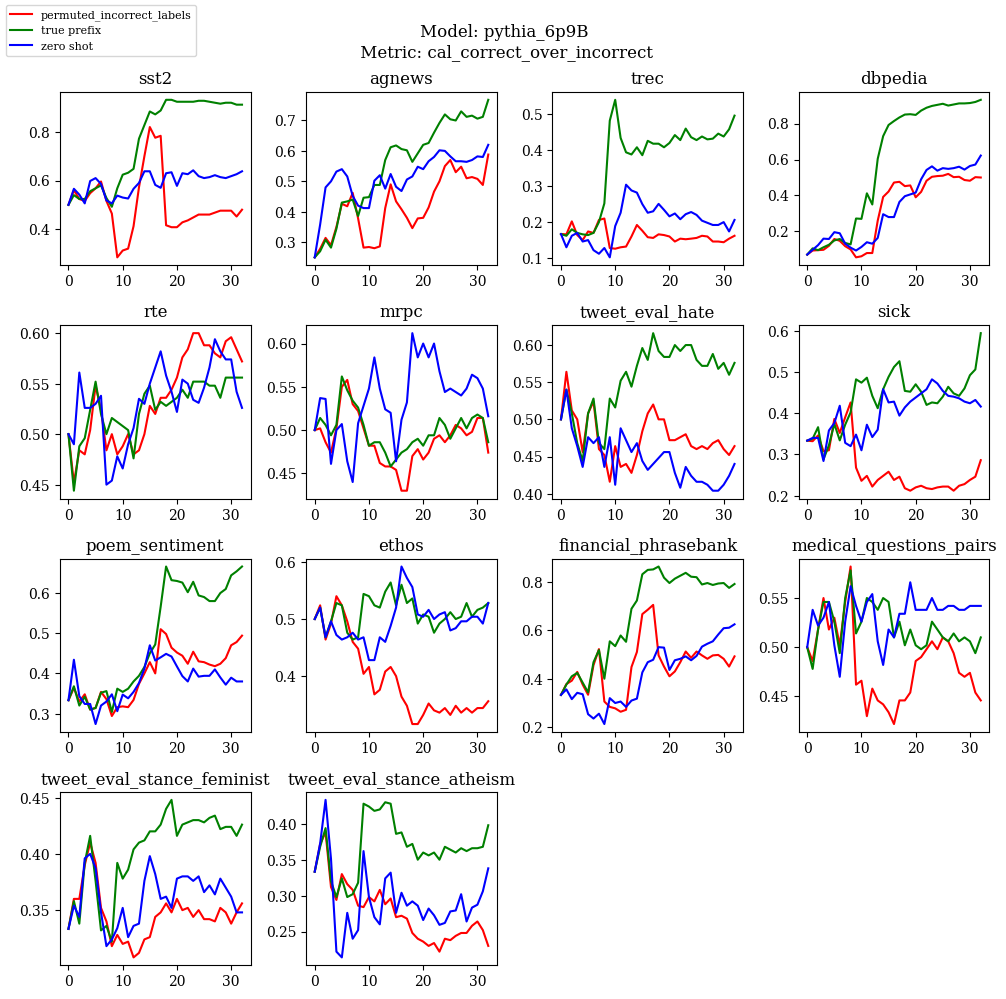

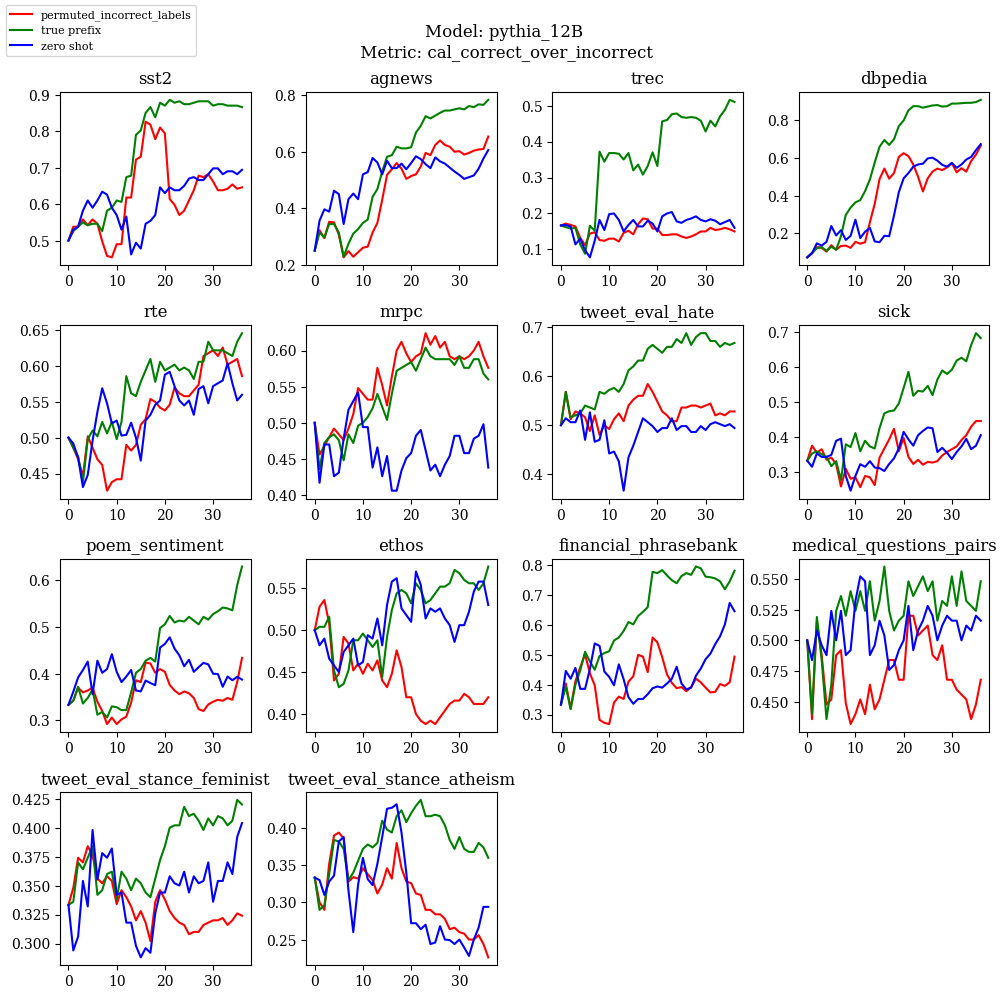

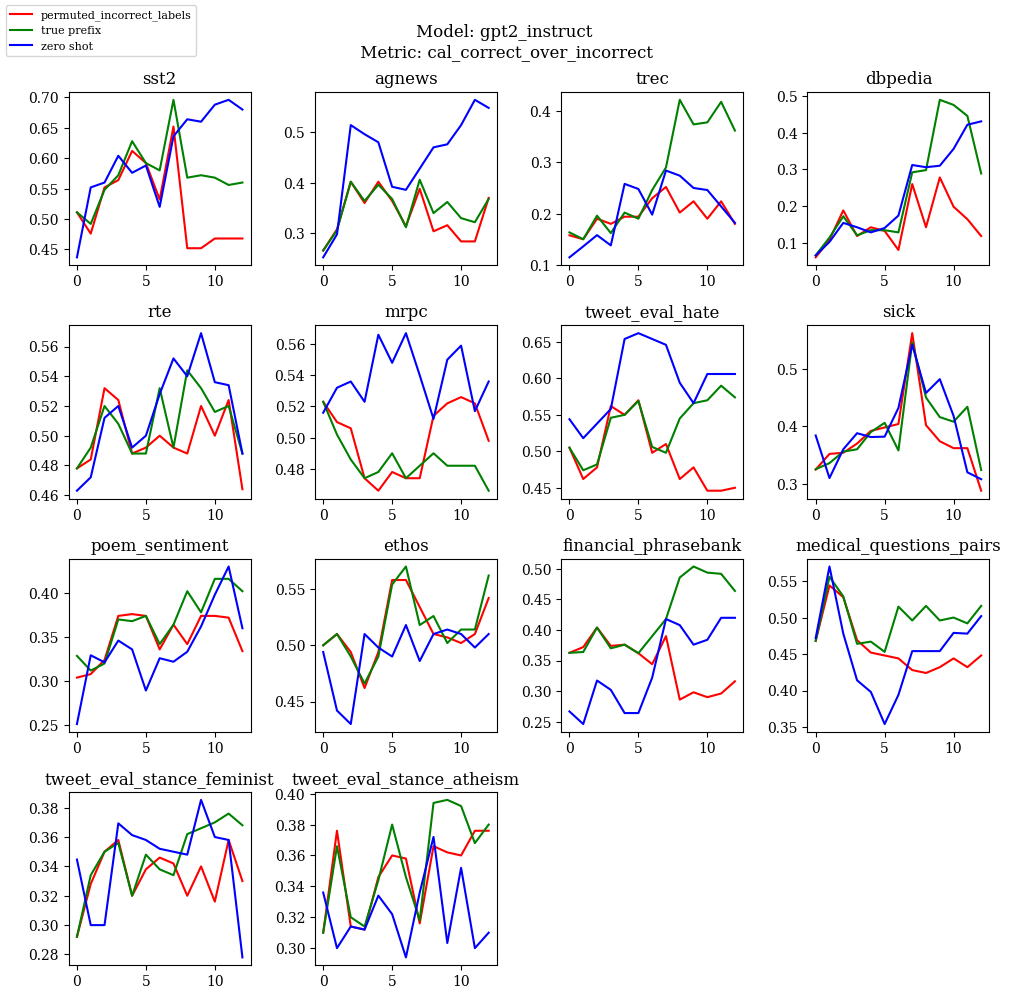

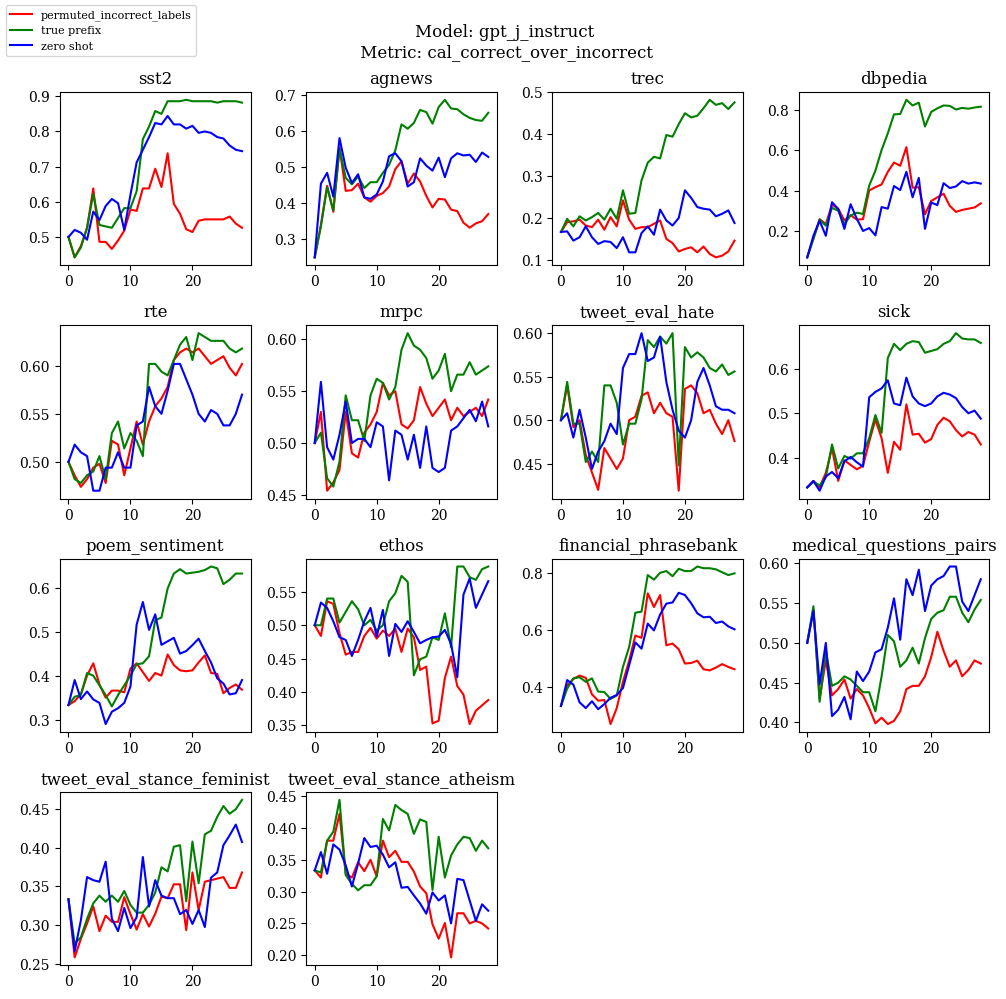

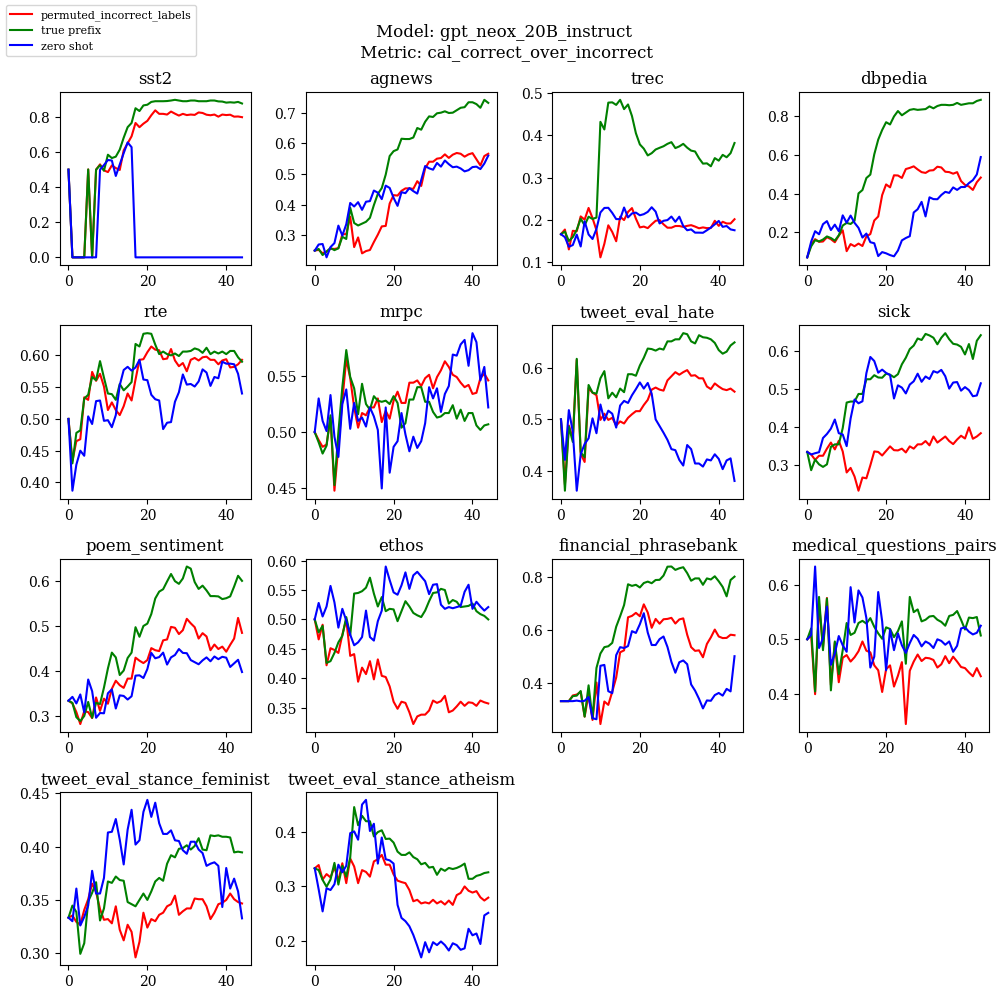

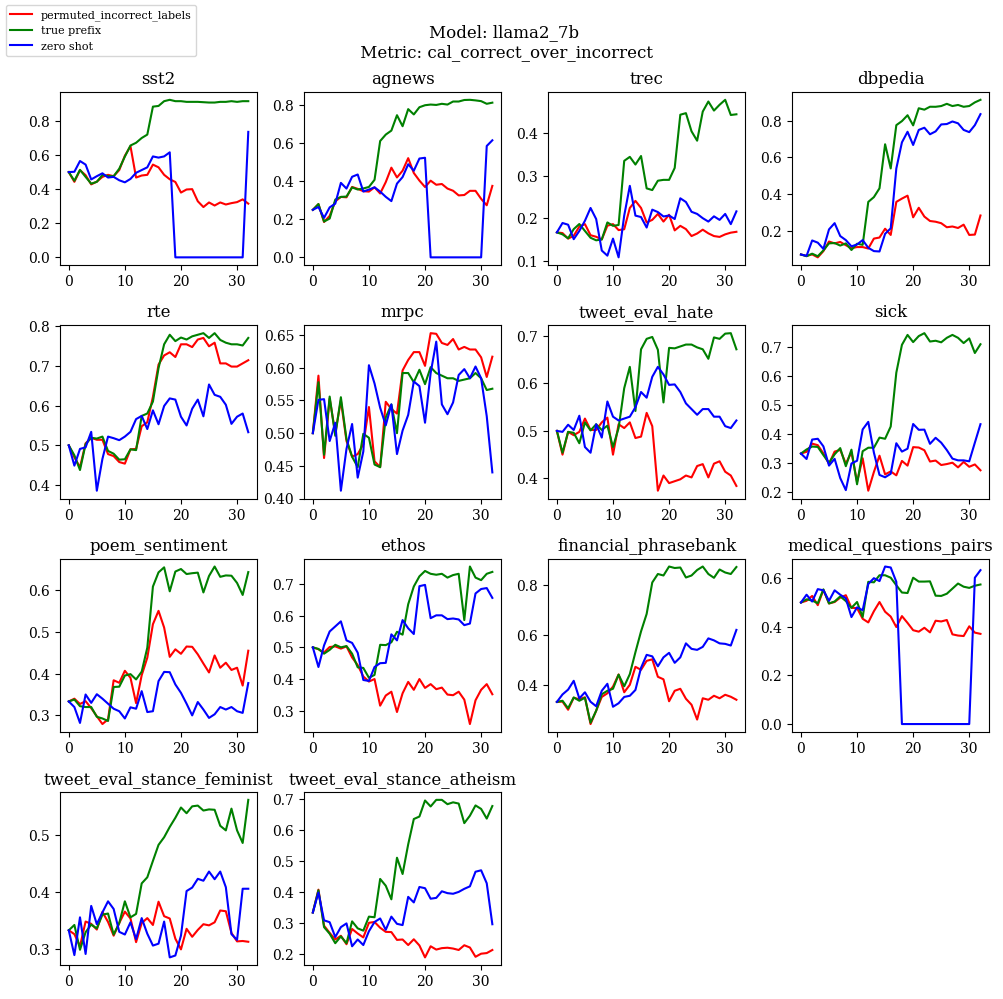

In [5]:
colors = [
    "red",
    "yellow",
    "orange",
]
plt.rcParams["font.family"] = "serif"

for model in models:
    num_layers = MODEL_PARAMS[model]["num_layers"]
    x_ax = list(range(num_layers + 1))
    for metric in metrics:
        num_subplots = len(datasets)
        grid_size = int(np.ceil(np.sqrt(num_subplots)))

        fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        fig.subplots_adjust(hspace=0.5)

        if len(datasets) == 1:  # Handle the case when there's only one dataset
            axs = np.array([[axs]])  # Wrap axs in an extra list

        for ax, dataset in zip(axs.flat, datasets):
            for j, setting in enumerate(settings):
                y = np.mean(results[model][setting][dataset][metric], axis=0)[0]
                y_ax = y[1, :, -1]
                ax.plot(x_ax, y_ax, color=colors[j])
            # true prefix
            y_ax = y[0, :, -1]
            ax.plot(x_ax, y_ax, "green")
            # zero shot
            y_ax = y[0, :, 0]
            ax.plot(x_ax, y_ax, color="blue")
            ax.set_title(f"{dataset}")

        for ax in axs.flat[len(datasets) :]:
            ax.set_visible(False)

        fig.suptitle(f"Model: {model}\n Metric: {metric}", fontsize=12)
        fig.legend(
            settings + ["true prefix", "zero shot"],
            ncol=1,
            loc="upper left",
            fontsize=8,
        )

        fig.tight_layout()
        plt.show()

## 4) Early Exiting Layers

In [6]:
setting = "permuted_incorrect_labels"
early_exiting_layers = {}
for model in models:
    num_layers = MODEL_PARAMS[model]["num_layers"]
    early_exit = [0] * num_layers
    for metric in metrics:
        for dataset in datasets:
            res_avg = np.mean(results[model][setting][dataset][metric], axis=0)[0]
            for layer in range(num_layers):
                early_exit[layer] += res_avg[1, layer, -1] - res_avg[1, -1, -1]
    max_value = max(early_exit)
    max_index = early_exit.index(max_value)
    early_exiting_layers[model] = max_index

print("*Early Exiting Layers*")
print(early_exiting_layers)

*Early Exiting Layers*
{'gpt2_xl': 30, 'gpt_j': 16, 'gpt_neox_20B': 32, 'pythia_410M': 15, 'pythia_2p8B': 11, 'pythia_6p9B': 17, 'pythia_12B': 17, 'gpt2_instruct': 7, 'gpt_j_instruct': 16, 'gpt_neox_20B_instruct': 31, 'llama2_7b': 17}


In [7]:
with open('../../results/early_exiting_layers/early_exiting_layers.pickle', 'wb') as file:
    pickle.dump(early_exiting_layers, file)

In [8]:
print("*Early Exit Average Performance*\n")
for setting in settings:
    print(f"Setting: {setting}")
    for model in models:
        crit_lay = early_exiting_layers[model]
        print(f"Model: {model}")
        for metric in metrics:
            tp_diff = fp_diff = 0
            for dataset in datasets:
                res_avg = np.mean(results[model][setting][dataset][metric], axis=0)[0]
                tp_diff += res_avg[0, crit_lay, -1] - res_avg[0, -1, -1]
                fp_diff += res_avg[1, crit_lay, -1] - res_avg[1, -1, -1]
            tp_diff_avg = (tp_diff / len(datasets)) * 100
            fp_diff_avg = (fp_diff / len(datasets)) * 100
            print(f"True Prefix Delta: {tp_diff_avg:.{3}f}%")
            print(f"False Prefix Delta: {fp_diff_avg:.{3}f}%")
    print()

*Early Exit Average Performance*

Setting: permuted_incorrect_labels
Model: gpt2_xl
True Prefix Delta: -0.517%
False Prefix Delta: 2.658%
Model: gpt_j
True Prefix Delta: -1.538%
False Prefix Delta: 10.299%
Model: gpt_neox_20B
True Prefix Delta: 0.477%
False Prefix Delta: 0.869%
Model: pythia_410M
True Prefix Delta: -3.571%
False Prefix Delta: 0.890%
Model: pythia_2p8B
True Prefix Delta: -16.071%
False Prefix Delta: 7.200%
Model: pythia_6p9B
True Prefix Delta: -3.429%
False Prefix Delta: 1.800%
Model: pythia_12B
True Prefix Delta: -9.214%
False Prefix Delta: 0.729%
Model: gpt2_instruct
True Prefix Delta: 0.194%
False Prefix Delta: 5.586%
Model: gpt_j_instruct
True Prefix Delta: -3.107%
False Prefix Delta: 8.557%
Model: gpt_neox_20B_instruct
True Prefix Delta: 0.921%
False Prefix Delta: 0.926%
Model: llama2_7b
True Prefix Delta: -5.417%
False Prefix Delta: 6.270%



## 5) Critical Layers

In [9]:
print("*Critical Layers: 50% of Final Layer Gap*")
setting = "permuted_incorrect_labels"
for model in models:
    print(f"Model: {model}")
    num_layers = MODEL_PARAMS[model]["num_layers"]
    for metric in metrics:
        for dataset in datasets:
            demo_indx = MODEL_PARAMS[model]["max_demos"] - 1
            res_avg = np.mean(results[model][setting][dataset][metric], axis=0)[0]
            tp = res_avg[0, :, demo_indx]
            fp = res_avg[1, :, demo_indx]
            final_gap = tp[-1] - fp[-1]
            layer = np.argmax((tp - fp) / (final_gap + 1e-9) >= 0.50)
            print(f"Layer: {layer:02}. Dataset: {dataset}.")
        print()

*Critical Layers: 50% of Final Layer Gap*
Model: gpt2_xl
Layer: 22. Dataset: sst2.
Layer: 23. Dataset: agnews.
Layer: 22. Dataset: trec.
Layer: 24. Dataset: dbpedia.
Layer: 20. Dataset: rte.
Layer: 03. Dataset: mrpc.
Layer: 21. Dataset: tweet_eval_hate.
Layer: 21. Dataset: sick.
Layer: 22. Dataset: poem_sentiment.
Layer: 23. Dataset: ethos.
Layer: 23. Dataset: financial_phrasebank.
Layer: 03. Dataset: medical_questions_pairs.
Layer: 24. Dataset: tweet_eval_stance_feminist.
Layer: 42. Dataset: tweet_eval_stance_atheism.

Model: gpt_j
Layer: 14. Dataset: sst2.
Layer: 17. Dataset: agnews.
Layer: 14. Dataset: trec.
Layer: 11. Dataset: dbpedia.
Layer: 14. Dataset: rte.
Layer: 13. Dataset: mrpc.
Layer: 14. Dataset: tweet_eval_hate.
Layer: 13. Dataset: sick.
Layer: 14. Dataset: poem_sentiment.
Layer: 14. Dataset: ethos.
Layer: 14. Dataset: financial_phrasebank.
Layer: 13. Dataset: medical_questions_pairs.
Layer: 14. Dataset: tweet_eval_stance_feminist.
Layer: 14. Dataset: tweet_eval_stance_at